In [1]:
# import importlib
# import local_utils; importlib.reload(local_utils)
from local_utils import *

# different normalization (standard, minmax, maxlog)
# mse vs mae
# fit on whole

# clean holidays
# better outliears handling
# since features

# different architecture
# LeakyReLU
# Batch Temporal Normalization
# Stateful
# Dropin
# Attention

/opt/conda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Seed: 7961730


### Loading data

In [2]:
merged_df = pd.read_hdf(data_dir+"prepared_data.hdf", key="key_0", mode="r")
print(len(merged_df))
merged_df.head()

7869006


,site_id,timestamp,forecast_id,value,part,time_diff,date,time,week_day,year,...,avg_temperature,avg_day_distance,avg_day_temperature,avg_month_distance,avg_month_temperature,has_weather,closest_temperature_base_diff,avg_temperature_base_diff,avg_day_temperature_base_diff,avg_month_temperature_base_diff
1138708,1,2014-09-03,1,909655.510515,train,1 days,2014-09-03,00:00:00,2,2014,...,19.600000,22.872779,21.184746,22.418264,18.695938,True,1.000000,1.600000,3.184746,0.695938
1141835,1,2014-09-04,1,1748273.124752,train,1 days,2014-09-04,00:00:00,3,2014,...,21.300000,22.840771,23.375000,22.418264,18.695938,True,2.000000,3.300000,5.375000,0.695938
1144962,1,2014-09-05,1,nan,train,1 days,2014-09-05,00:00:00,4,2014,...,23.350000,22.827057,26.521667,22.418264,18.695938,True,4.000000,5.350000,8.521667,0.695938
1148089,1,2014-09-06,1,nan,train,1 days,2014-09-06,00:00:00,5,2014,...,21.600000,22.872779,19.944068,22.418264,18.695938,True,3.000000,3.600000,1.944068,0.695938
1151216,1,2014-09-07,1,nan,train,1 days,2014-09-07,00:00:00,6,2014,...,15.800000,22.840771,17.680000,22.418264,18.695938,True,5.000000,2.200000,0.320000,0.695938


In [3]:
# merged_df.isnull().sum()

### Handling NaNs

In [4]:
print(merged_df["value"].isnull().sum())
merged_df.dropna(subset=["value"], inplace=True)
print(merged_df["value"].isnull().sum())

86601
0


In [5]:
train_cond = merged_df["part"]=="train"
test_cond = merged_df["part"]=="test"
merged_df["normalized_value"] = merged_df["value"]

merged_df.loc[train_cond, "normalized_value"] = merged_df[train_cond]\
                                                        .groupby("forecast_id")["normalized_value"]\
                                                        .transform(lambda group: fit_transform(group, minmax=False))

In [6]:
norm_mean = merged_df[train_cond]["normalized_value"].mean()
norm_std = merged_df[train_cond]["normalized_value"].std()
merged_df[train_cond][["normalized_value"]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,normalized_value
count,6473229.000000
mean,-0.006375
std,0.995711
min,-18.623330
1%,-1.756175
5%,-1.250574
25%,-0.811081
50%,-0.200699
75%,0.802794
95%,1.636672


In [7]:
merged_df.loc[train_cond&(np.abs(merged_df["normalized_value"]-norm_mean)>=3*norm_std), "value"] = np.nan
print(merged_df["value"].isnull().sum())
merged_df.dropna(subset=["value"], inplace=True)
print(merged_df["value"].isnull().sum())
merged_df.drop(columns="normalized_value", inplace=True)

28501
0


### Prepare features

In [8]:
merged_df[merged_df["site_id"]==93][["site_id", "forecast_id", "timestamp", "value"]].head()

,site_id,forecast_id,timestamp,value
834530,93,1955,2014-05-22 16:30:00,110.325792
834754,93,1955,2014-05-22 18:30:00,90.735231
834866,93,1955,2014-05-22 19:30:00,120.636614
834978,93,1955,2014-05-22 20:30:00,113.419038
835090,93,1955,2014-05-22 21:30:00,80.424409


In [9]:
merged_df["cat_site_id"] = merged_df["site_id"]

id_cols = ["forecast_id", "site_id", "part", "timestamp"]
value_cols = ["value"]
num_cols = ["surface", "base_temperature", 
            "closest_distance", "closest_temperature", "closest_temperature_base_diff",
            "avg_distance", "avg_temperature", "avg_temperature_base_diff",
            "avg_day_distance", "avg_day_temperature", "avg_day_temperature_base_diff",
            "avg_month_distance", "avg_month_temperature", "avg_month_temperature_base_diff"]
bin_cols = ["is_holiday", "is_day_off", "has_weather"]
cat_cols = ["cat_site_id", "time_diff", "month", "week", "day", "hour", "time", "week_day", "sampling", "holiday"]
cat_sizes_map = {col_name: merged_df[col_name].unique().shape[0] for col_name in cat_cols}

In [10]:
merged_df = merged_df.loc[:,id_cols + value_cols + num_cols + bin_cols + cat_cols]\
    .pipe(fit_transform_cols, cols=num_cols, new_cols=num_cols, groupby=None, minmax=True, feature_range=(-1,1))\
    .pipe(binarize_cols, cols=bin_cols, new_cols=bin_cols)\
    .pipe(factorize_cols, cols=cat_cols, new_cols=cat_cols)

In [11]:
train_df = merged_df[merged_df["part"] == "train"].copy().reset_index(drop=True)
test_df = merged_df[merged_df["part"] == "test"].copy().reset_index(drop=True) 

In [12]:
forecast_scalers = {}
site_scalers = {}

# train_df = train_df\
#     .pipe(fit_maxlog_scalers, col="value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)\
#     .pipe(transform_maxlog, col="value", new_col="scaled_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)
    
train_df = train_df\
    .pipe(fit_scalers, col="value", forecast_scalers=forecast_scalers, site_scalers=site_scalers, minmax=False, feature_range=(-1,1))\
    .pipe(transform, col="value", new_col="scaled_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)
    
train_df["scaled_value"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

count   6444728.000000
mean         -0.005818
std           0.995479
min         -13.632182
1%           -1.763475
5%           -1.266635
25%          -0.824906
50%          -0.217861
75%           0.830617
95%           1.654385
99%           2.332414
max          19.083962
Name: scaled_value, dtype: float64

In [13]:
train_df[train_df["scaled_value"]>10].groupby("forecast_id").size()

forecast_id
698     1
1964    1
3733    2
4838    1
5278    2
5279    3
dtype: int64

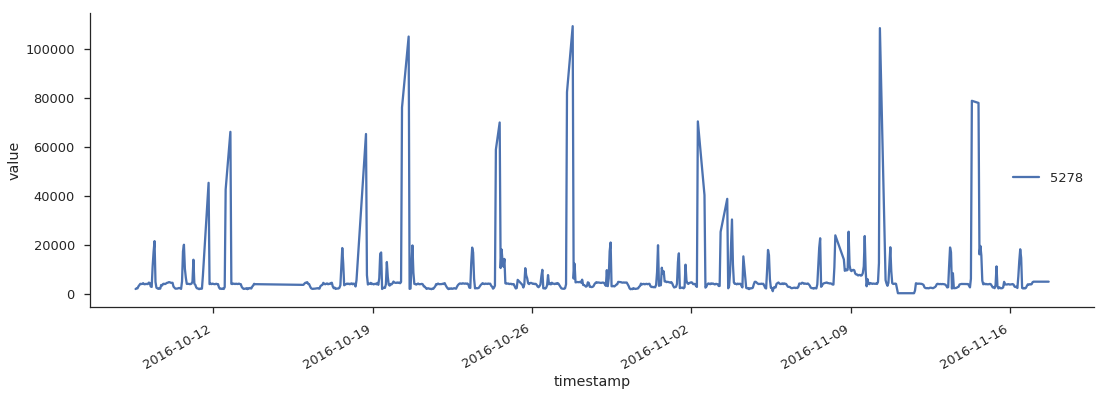

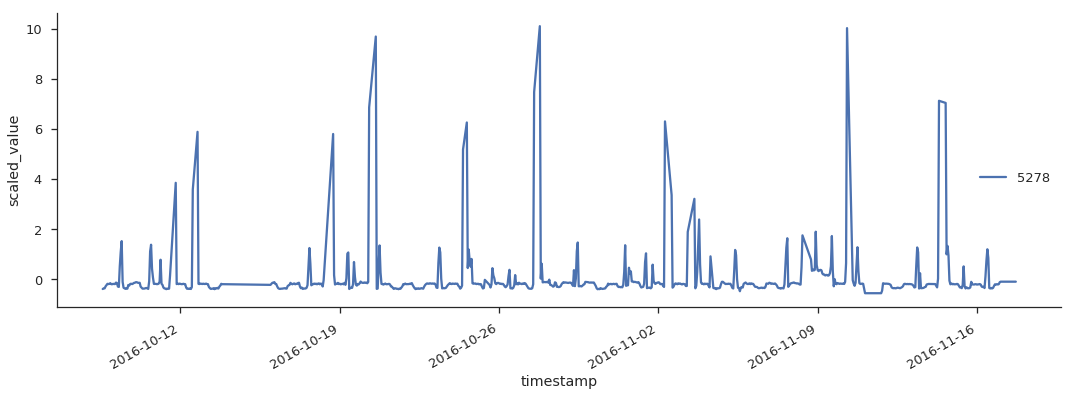

In [14]:
cond_id = 5278
cond_col = "forecast_id"
# cond_col = "site_id"

plot_graph(train_df, cond_id, cond_col, "value")
plot_graph(train_df, cond_id, cond_col, "scaled_value")

### Train model

In [15]:
valid_frac = 0.1
train_df.loc[np.concatenate(train_df.groupby("forecast_id")["part"]\
                                    .apply(lambda group: group.tail(math.floor(len(group)*valid_frac)).index).values), "part"] = "valid"

In [16]:
trn_cond = train_df["part"] == "train"
val_cond = train_df["part"] == "valid"

X_trn = train_df[trn_cond][num_cols+bin_cols+cat_cols].values
y_trn = train_df[trn_cond]["scaled_value"].values
X_val = train_df[val_cond][num_cols+bin_cols+cat_cols].values
y_val = train_df[val_cond]["scaled_value"].values

train_batch_size = 64
pred_batch_size = 10*1024
trn_seq = FeatureSequence(X_trn, y_trn, batch_size=train_batch_size, shuffle=True)
val_seq = FeatureSequence(X_val, y_val, batch_size=pred_batch_size, shuffle=False)

In [17]:
def get_cat_emb(cat_name, cat_size, max_emb_size=50):
    emb_size = min([(cat_size+2)//3, max_emb_size]) # (cat_size+1)//2
    
    emb_inp = Input((1,), dtype='int64', name=cat_name+'_in')
    emb = Embedding(cat_size, emb_size, trainable=True, name=cat_name+'_emb')(emb_inp)
    emb = Lambda(lambda emb: K.squeeze(emb, axis=-2), name=cat_name+'_squeeze_emb')(emb)
    return emb_inp, emb

def RossmanMLP(output_size, num_cols, bin_cols, cat_cols, cat_sizes_map, activation="linear"):
    num_inps = []
    for num_col in num_cols:
        num_inp = Input((1,), name=num_col+'_in')
        num_inps.append(num_inp)
        
    bin_inps = []
    for bin_col in bin_cols:
        bin_inp = Input((1,), name=bin_col+'_in')
        bin_inps.append(bin_inp)
    
    emb_inps = []
    embs = []
    for cat_col in cat_cols:
        emb_inp, emb = get_cat_emb(cat_col, cat_sizes_map[cat_col])
        emb_inps.append(emb_inp)
        embs.append(emb)
    
    x = concatenate(num_inps+bin_inps+embs, name='concat')
    x = Dropout(0.15)(x)
    
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.15)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.15)(x)

    x_output = Dense(output_size, activation=activation)(x)
    return Model(inputs=num_inps + bin_inps + emb_inps, outputs=x_output)

model_fun = RossmanMLP
model_name = model_fun.__name__
model = model_fun(1, num_cols, bin_cols, cat_cols, cat_sizes_map, activation="linear")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_site_id_in (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
time_diff_in (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
week_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
day_in (In

In [18]:
mse_trn_eval = MSEEvaluation(split_inputs(X_trn), y_trn, name='trn', batch_size=pred_batch_size)
mse_val_eval = MSEEvaluation(split_inputs(X_val), y_val, name='val', batch_size=pred_batch_size)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint(models_dir+model_name+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=0, min_lr=0.0001, verbose=1)
# lr_schedule = LearningRateScheduler(lr_change, verbose=1)
# tensorboard = TensorBoard(log_dir='logs', write_graph=False)

In [19]:
# model.compile(loss="mae", optimizer=optimizers.Adam(0.0003))
model.compile(loss="mse", optimizer=optimizers.Adam(0.0003))
# model.compile(loss=keras_rmse, optimizer=optimizers.Adam(0.0003))

In [20]:
epochs=50
model.fit_generator(
    generator=trn_seq, steps_per_epoch=len(trn_seq),
    validation_data=val_seq, validation_steps=len(val_seq),
    initial_epoch=0, epochs=epochs, shuffle=False, verbose=1,
    callbacks=[mse_val_eval, early_stop, model_checkpoint, lr_reduce],
    use_multiprocessing=False, workers=cpu_cores, max_queue_size=8*cpu_cores)

Epoch 1/50
90674/90674 [==============================] - 297s 3ms/step - loss: 0.4326 - val_loss: 0.4496
val_mse: 0.44961698; val_rmse: 0.67053484;

Epoch 00001: val_loss improved from inf to 0.44962, saving model to models/RossmanMLP.h5
Epoch 2/50
90674/90674 [==============================] - 295s 3ms/step - loss: 0.3868 - val_loss: 0.4461
val_mse: 0.44605676; val_rmse: 0.66787481;

Epoch 00002: val_loss improved from 0.44962 to 0.44606, saving model to models/RossmanMLP.h5
Epoch 3/50
90674/90674 [==============================] - 295s 3ms/step - loss: 0.3684 - val_loss: 0.4458
val_mse: 0.44576110; val_rmse: 0.66765343;

Epoch 00003: val_loss improved from 0.44606 to 0.44576, saving model to models/RossmanMLP.h5
Epoch 4/50
90674/90674 [==============================] - 295s 3ms/step - loss: 0.3545 - val_loss: 0.4462
val_mse: 0.44619945; val_rmse: 0.66798162;

Epoch 00004: val_loss did not improve

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00022500001068692654.
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90674/90674 [==============================] - 295s 3ms/step - loss: 0.3311 - val_loss: 0.4488
val_mse: 0.44882647; val_rmse: 0.66994513;

Epoch 00006: val_loss did not improve

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001687500080151949.
Epoch 7/50
31085/90674 [=========>....................] - ETA: 3:13 - loss: 0.3232

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



90674/90674 [==============================] - 296s 3ms/step - loss: 0.3215 - val_loss: 0.4456
val_mse: 0.44558544; val_rmse: 0.66752186;

Epoch 00007: val_loss did not improve

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00012656250328291208.
Epoch 8/50
90674/90674 [==============================] - 295s 3ms/step - loss: 0.3140 - val_loss: 0.4478
val_mse: 0.44779846; val_rmse: 0.66917745;

Epoch 00008: val_loss did not improve

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 00008: early stopping


### Evaluation

In [21]:
del model
model = load_model(models_dir+model_name+'.h5', compile=True, custom_objects={"keras_rmse":keras_rmse})

In [22]:
trn_pred = model.predict(split_inputs(X_trn), batch_size=pred_batch_size, verbose=0)
val_pred = model.predict(split_inputs(X_val), batch_size=pred_batch_size, verbose=0)

train_df.loc[trn_cond, "pred_value_scaled"] = trn_pred
train_df.loc[val_cond, "pred_value_scaled"] = val_pred

In [23]:
# PREDICTIONS
print("Train:")
print_report(train_df[trn_cond], "scaled_value", "pred_value_scaled")
print("\nValid:")
print_report(train_df[val_cond], "scaled_value", "pred_value_scaled")

Train:

NWRMSE: 3248083774344.9395; 
RMSE: 0.49512109090916323; 
MSE: 0.29249112684300005; 
MAE: 0.36846024030419383; 
R2: -6.486229357725149e+29;

Valid:

NWRMSE: 4866199276751.014; 
RMSE: 0.5738202807645639; 
MSE: 0.4524912862518506; 
MAE: 0.45769280586723204; 
R2: -7.7516177792075e+30;


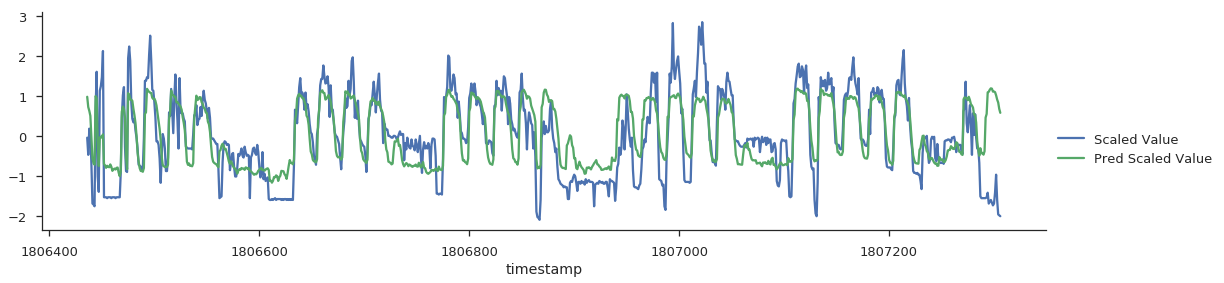

In [24]:
cond_id = 1955 #1955
cond_col = "forecast_id"
# cond_col = "site_id"

train_df[(train_df[cond_col] == cond_id)]["scaled_value"]\
    .plot(y="scaled_value", figsize=(18, 4), label="Scaled Value")
train_df[(train_df[cond_col] == cond_id)]["pred_value_scaled"]\
    .plot(y="pred_value_scaled", figsize=(18, 4), label="Pred Scaled Value")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [25]:
train_df = train_df.pipe(inverse, col="pred_value_scaled", new_col="pred_value", 
                         forecast_scalers=forecast_scalers, site_scalers=site_scalers)

In [26]:
# PREDICTIONS
print("Train:")
print_report(train_df[trn_cond], "value", "pred_value")
print("\nValid:")
print_report(train_df[val_cond], "value", "pred_value")

Train:

NWRMSE: 0.230164499434438; 
RMSE: 22273.47032814897; 
MSE: 28764984120.992542; 
MAE: 17037.21851023995; 
R2: -2.0301644848955364e+24;

Valid:

NWRMSE: 0.38558591256975844; 
RMSE: 26349.050274505917; 
MSE: 50215425996.97539; 
MAE: 21940.047603455023; 
R2: -4.2214992813045444e+27;


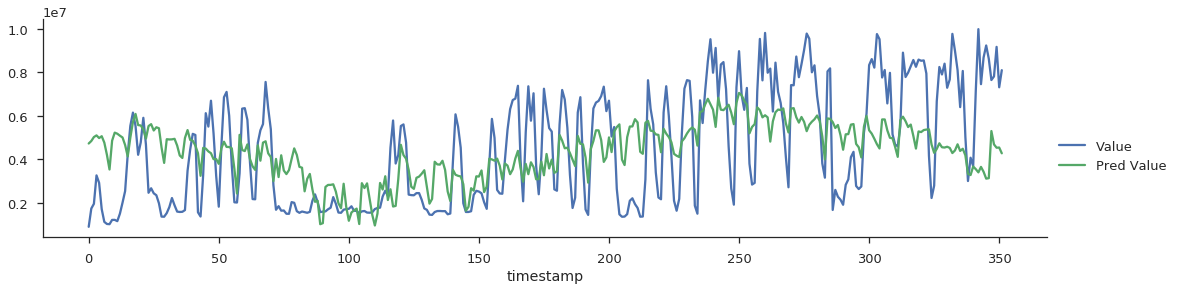

In [27]:
cond_id = 1 #1955
cond_col = "forecast_id"
# cond_col = "site_id"

train_df[(train_df[cond_col] == cond_id)]["value"].plot(y="value", figsize=(18, 4), label="Value")
train_df[(train_df[cond_col] == cond_id)]["pred_value"].plot(y="pred_value", figsize=(18, 4), label="Pred Value")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [28]:
train_df[train_df["site_id"]==1][["site_id", "forecast_id", "timestamp", "value", "pred_value",]].head(10)

,site_id,forecast_id,timestamp,value,pred_value
0,1,1,2014-09-03,909655.510515,4729253.693328
1,1,1,2014-09-04,1748273.124752,4844421.549776
2,1,1,2014-09-08,1964877.999024,5025960.054988
3,1,1,2014-09-09,3266903.917698,5101673.856395
4,1,1,2014-09-10,2926094.474576,4980007.818564
5,1,1,2014-09-11,1720502.151377,5063940.633190
6,1,1,2014-09-12,1136248.107574,4771682.306896
7,1,1,2014-09-13,1040528.600199,4212731.010128
8,1,1,2014-09-14,1030667.685509,3538333.397861
9,1,1,2014-09-15,1226753.424487,4859140.144061


In [29]:
wrmse_all = metric_by_group(train_df[val_cond], WRMSE, "value", "pred_value")
print(wrmse_all.idxmin())
print(wrmse_all.idxmax())
wrmse_all.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.99])

3470
3237


count   6963.000000
mean       0.385586
std        2.900784
min        0.000000
10%        0.050302
25%        0.096635
50%        0.162974
75%        0.308063
95%        0.912830
99%        1.892003
max      119.014174
dtype: float64

In [30]:
rmse_all = metric_by_group(train_df[val_cond], rmse, "value", "pred_value")
print(rmse_all.idxmin())
print(rmse_all.idxmax())
rmse_all.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.99])

3470
1649


count      6963.000000
mean      26349.050275
std      222549.470031
min           0.000000
10%         228.175674
25%         723.219535
50%        2476.507292
75%        8877.201106
95%       51079.128296
99%      420672.961372
max     8021202.608128
dtype: float64

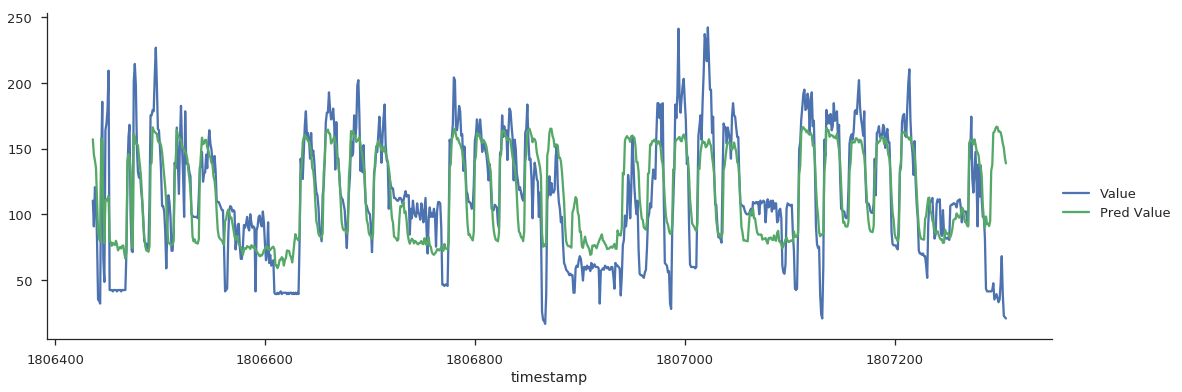

In [33]:
cond_id = 1955 # 4292
cond_col = "forecast_id"
# cond_col = "site_id"

train_df[(train_df[cond_col] == cond_id)]["value"].plot(y="value", figsize=(18, 6), label="Value")
train_df[(train_df[cond_col] == cond_id)]["pred_value"].plot(y="pred_value", figsize=(18, 6), label="Pred Value")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

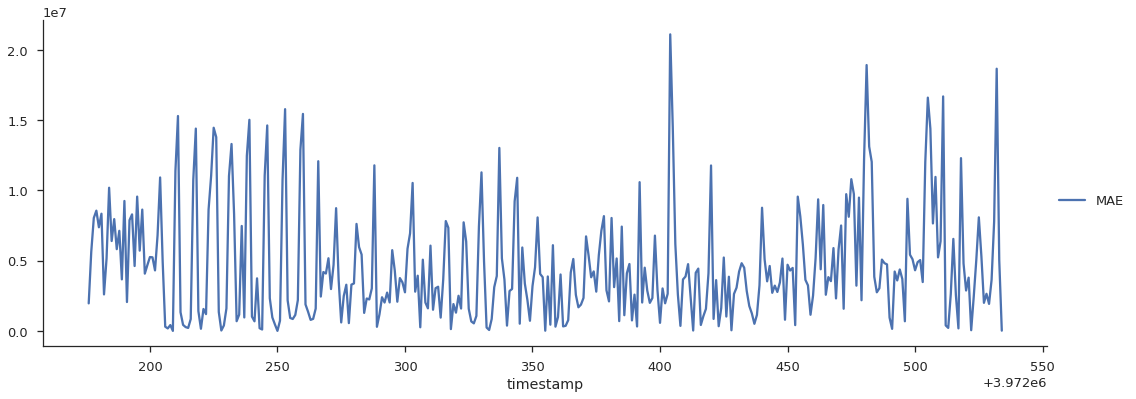

In [32]:
np.abs(train_df[(train_df[cond_col] == cond_id)]["value"]-train_df[(train_df[cond_col] == cond_id)]["pred_value"])\
.plot(y="mae", figsize=(18, 6), label="MAE")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [ ]:
stop

### Prediction

In [ ]:
del model
model = load_model(models_dir+model_name+'.h5', compile=True, custom_objects={"keras_rmse":keras_rmse})

In [ ]:
X_test = test_df[num_cols+cat_cols].values
test_pred = model.predict(split_inputs(X_test), batch_size=pred_batch_size, verbose=0)
test_df["pred_value_scaled"] = test_pred

test_df = test_df\
    .pipe(inverse, col="pred_value_scaled", new_col="pred_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)

In [ ]:
cond_id = 5
cond_col = "forecast_id"
# cond_col = "site_id"

ax = train_df[(train_df[cond_col] == cond_id)].plot(x="timestamp", y="value", figsize=(18, 6), label="Value")
ax = train_df[(train_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 6), label="Pred Value")
test_df[(test_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 6), label="Pred Test Value")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.tight_layout()
plt.xlabel("timestamp")
sns.despine()

In [ ]:
stop

In [ ]:
submission_df = pd.read_csv(data_dir + 'submission_format.csv', encoding='utf-8', low_memory=False, header=0,
                            names=['obs_id', 'site_id', 'timestamp', 'forecast_id', 'value'])
submission_df["timestamp"] = pd.to_datetime(submission_df["timestamp"])
submission_df = submission_df.merge(test_df[["forecast_id", "site_id", "timestamp", "pred_value"]], 
                                            how="left", on=["forecast_id", "site_id", "timestamp"])
submission_df.drop(columns="value", inplace=True)
submission_df.rename(columns={"obs_id": "obs_id", "site_id": "SiteId", 
                              "timestamp": "Timestamp", "forecast_id": 
                              "ForecastId", "pred_value": "Value"}, inplace=True)
submission_df.head()

In [ ]:
submission_name = 'std_scaled_mae_mlp.csv'
submission_df.to_csv(results_dir+submission_name, index=False)
FileLink(results_dir+submission_name)

### End